# Dataset 4 - Capital Punishment
## Parameters

In [1]:
#ABC_Generator 
std = 1
mean = 1
prior = 0

#Discriminator 
hidden_nodes = 7

## Import Libraries and Dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cpunishDataset
import train_test
import ABC_train_test
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks

import torch
from torch import nn
from torch.utils.data import Dataset , DataLoader 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from statistics import mean
import pandas as pd
%matplotlib inline

[[ 1.         -0.78987947 -0.15604396 -0.05494505 -0.5731902   0.65634511]
 [-0.78987947  1.          0.08140819  0.07700775  0.42573825 -0.50722951]
 [-0.15604396  0.08140819  1.          0.64395604  0.72111026 -0.37030281]
 [-0.05494505  0.07700775  0.64395604  1.          0.46225016  0.13747769]
 [-0.5731902   0.42573825  0.72111026  0.46225016  1.         -0.50367775]
 [ 0.65634511 -0.50722951 -0.37030281  0.13747769 -0.50367775  1.        ]]


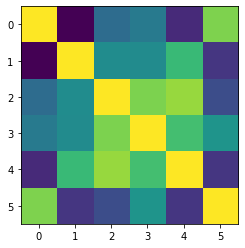

[[ 1.          0.06373626  0.16043956  0.01978022 -0.02857143 -0.03736264]
 [ 0.06373626  1.          0.04615385  0.04615385  0.00659341  0.01538462]
 [ 0.16043956  0.04615385  1.          0.04615385 -0.14725275 -0.05054945]
 [ 0.01978022  0.04615385  0.04615385  1.         -0.01538462  0.08131868]
 [-0.02857143  0.00659341 -0.14725275 -0.01538462  1.          0.16483516]
 [-0.03736264  0.01538462 -0.05054945  0.08131868  0.16483516  1.        ]]


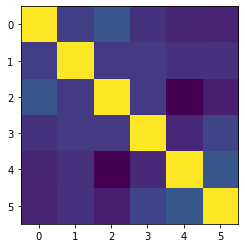

In [4]:
#Load the dataset 
X,Y = cpunishDataset.cpunish_data()
n_features = 6

# Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:             EXECUTIONS   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                 -0.098
Method:                 Least Squares   F-statistic:                    0.8073
Date:                Thu, 07 Oct 2021   Prob (F-statistic):              0.595
Time:                        08:29:21   Log-Likelihood:                -16.184
No. Observations:                  14   AIC:                             46.37
Df Residuals:                       7   BIC:                             50.84
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0      0.291          0      1.0

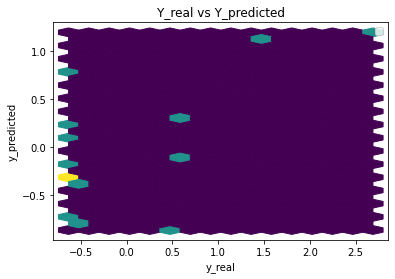

Performance Metrics
Mean Squared Error: 0.5910184401346178
Mean Absolute Error: 0.6107560111864075
Manhattan distance: 8.550584156609705
Euclidean distance: 2.87650102761752


In [5]:
 [coeff,y_pred] = statsModel.statsModel(X,Y)

# Generator and Discriminator Networks 

**GAN Generator**

In [6]:
class Generator(nn.Module):
  def __init__(self,n_input):
    super().__init__()
    #Input to Output Layer Linear Transformation
    self.output = nn.Linear(n_input,1)

  def forward(self, x):
    #Pass the input tensor through the operations 
    x = self.output(x)
    return x 

**GAN Discriminator**

In [7]:
class Discriminator(nn.Module):
  def __init__(self,n_input,hiddenNodes):
    super().__init__()
    self.hidden = nn.Linear(n_input,hiddenNodes)
    self.output = nn.Linear(hiddenNodes,1)
    #Define LeakyRelu Activation and sigmoid output
    self.sigmoid = nn.Sigmoid()
    self.leakyRelu = nn.LeakyReLU()

  def forward(self, x):
    #Pass the input tensor through the operations 
    x = self.hidden(x)
    x = self.leakyRelu(x)
    x = self.output(x)
    x = self.sigmoid(x)
    return x 

**ABC Generator**

The ABC generator is defined as follows:

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 

$\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else

$\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from stats model

Parameters : $\mu$ and $\sigma^{*}$

In [8]:
def ABC_pre_generator(x_batch,coeff,variance,mean,device):

  coeff_len = len(coeff)

  if mean == 0:
    weights = np.random.normal(0,variance,size=(coeff_len,1))
    weights = torch.from_numpy(weights).reshape(coeff_len,1)
  else:
    weights = []
    for i in range(coeff_len):
      weights.append(np.random.normal(coeff[i],variance))
    weights = torch.tensor(weights).reshape(coeff_len,1)
    
  y_abc =  torch.matmul(x_batch,weights.float())
  gen_input = torch.cat((x_batch,y_abc),dim = 1).to(device)
  return gen_input 

# GAN Model

In [9]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
generator = Generator(n_features+2)
discriminator = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [11]:
sample_size = len(real_dataset)
n_epochs = 30000
batch_size = sample_size

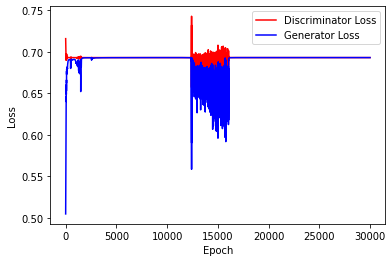

In [12]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

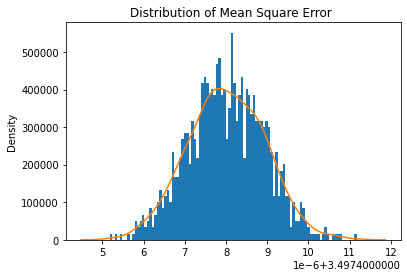

Mean Square Error: 3.4974080131556655


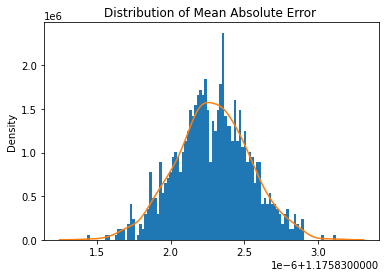

Mean Absolute Error: 1.1758322857533183


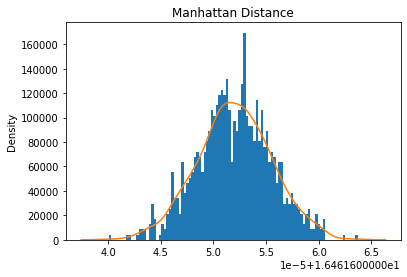

Mean Manhattan Distance: 16.461652000546454


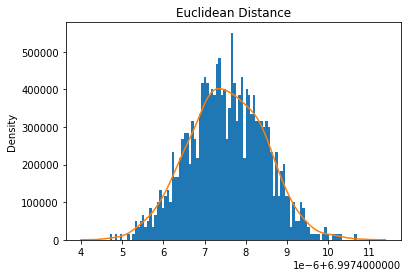

Mean Euclidean Distance: 16.461652000546454


In [13]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

In [14]:
gen = Generator(n_features+2)
disc = Discriminator(n_features+2,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [15]:
n_epoch_abc = 10000
batch_size = sample_size

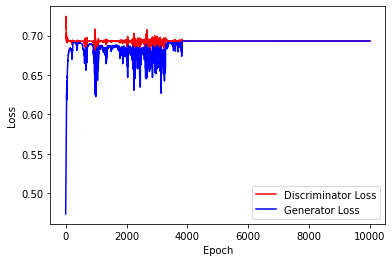

In [16]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epoch_abc,criterion,coeff,mean,std,device)

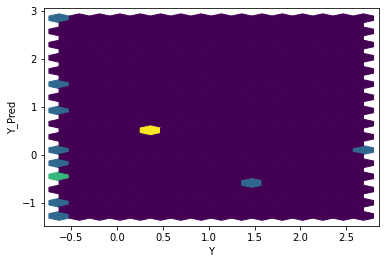

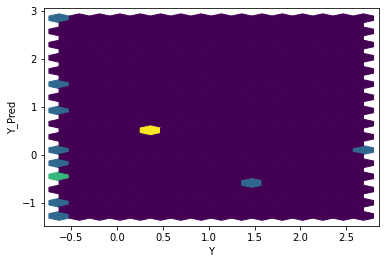

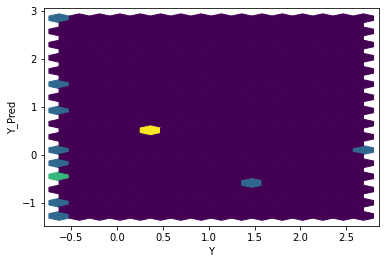

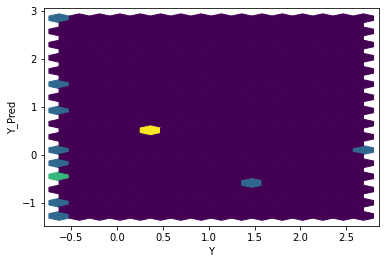

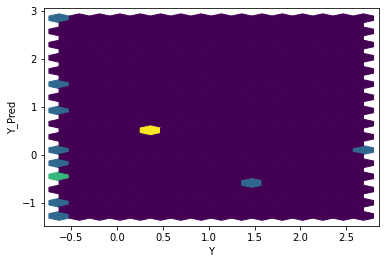

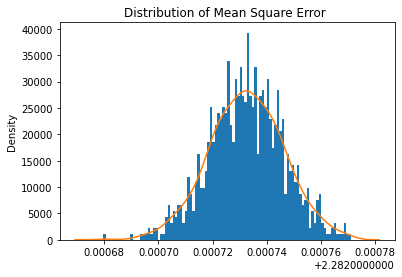

Mean Square Error: 2.282732532931899


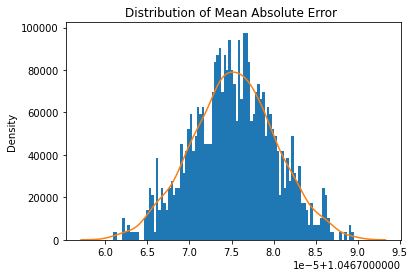

Mean Absolute Error: 1.0467752872290357
Mean Manhattan Distance: 14.654854021206498


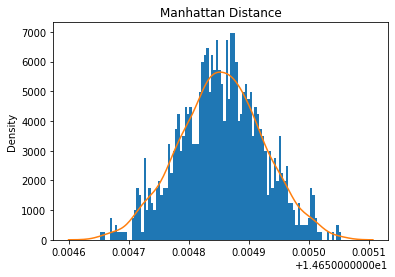

Mean Euclidean Distance: 5.653163314530691


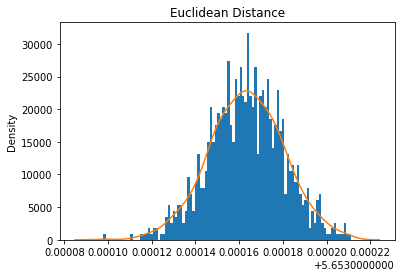

In [17]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,std,device)

**Sanity Check**

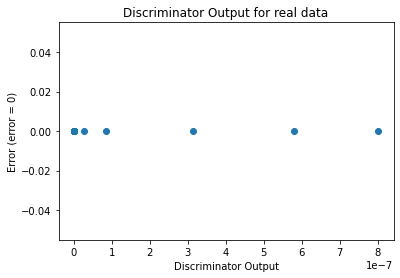

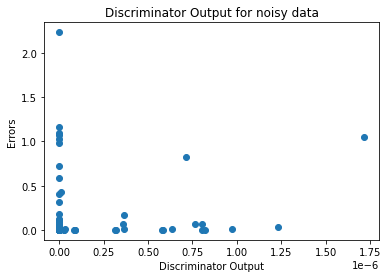

In [18]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Visualisation of Trained GAN Generator**

In [19]:
for name, param in gen.named_parameters():
    print(name,param)

output.weight Parameter containing:
tensor([[ 9.6349e-02,  9.8720e-02,  2.1902e-01,  6.4719e-01,  1.2843e+00,
         -3.9254e-01, -2.1738e+00,  4.7465e-06]], requires_grad=True)
output.bias Parameter containing:
tensor([0.1216], requires_grad=True)
